### Student: HO Quang Phuoc, MVA ENS Paris-Saclay

In [1]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

In [40]:
from umap import UMAP

In [ ]:
## UMAP
# try:
#   import google.colab
#   IN_COLAB = True
# except:
#   IN_COLAB = False

# if IN_COLAB:
#   print("Using Google Colab")
#   !pip install umap-learn
#   from umap import UMAP
#   !pip install adapt
# else:
#   from umap import UMAP

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (MacBook) device found.")
    print("Number of MPS cards: ", torch.mps.device_count())
    print(
        "Total MPS memory {0:.2f} GB".format(
            torch.mps.recommended_max_memory() / pow(10, 9)
        )
    )
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA device found.")
    print(
        "Number of GPU cards: ",
        torch.cuda.device_count(),
        "\nWhich card GPU?",
        torch.cuda.get_device_name(0),
    )
    print(
        "Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB".format(
            torch.cuda.mem_get_info()[0] / pow(10, 9),
            torch.cuda.mem_get_info()[1] / pow(10, 9),
        )
    )
else:
    device = torch.device("cpu")
    print("No MPS or CUDA has been found. PyTorch will use CPU.")

Using torch 2.5.1+cu121
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.73 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [3]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(
    root=DATASET_PATH,
    train=True,
    download=True,
    transform=T.Compose([T.Pad(2), T.ToTensor()]),
)
MNIST_test_dataset = MNIST(
    root=DATASET_PATH,
    train=False,
    download=True,
    transform=T.Compose([T.Pad(2), T.ToTensor()]),
)

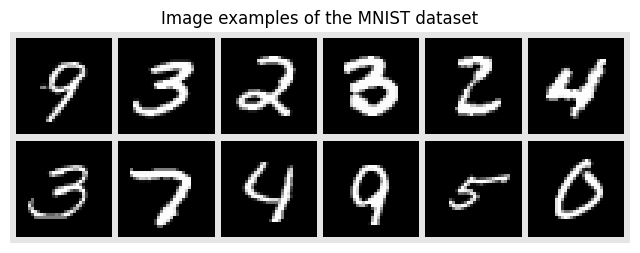

In [4]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack(
    [
        MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0]
        for idx in range(NUM_IMAGES)
    ],
    dim=0,
)
img_grid = torchvision.utils.make_grid(
    MNIST_images, nrow=6, normalize=True, pad_value=0.9
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [5]:
# This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()

In [6]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()
    )
)
print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()
    )
)

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [7]:
MNIST_train_loader = DataLoader(
    MNIST_train_dataset, batch_size=len(MNIST_train_dataset)
)
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()

In [8]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()
    )
)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()
    )
)

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


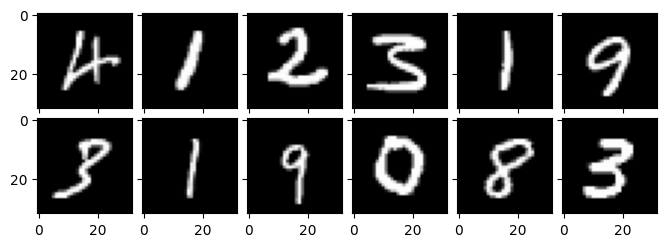

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES = 12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0, len(MNIST_Xtrain_ima), 12), :, :]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(2, 6),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [10]:
SVHN_train_dataset = SVHN(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=T.Compose([T.Grayscale(), T.ToTensor()]),
)
SVHN_test_dataset = SVHN(
    root=DATASET_PATH,
    split="test",
    download=True,
    transform=T.Compose([T.Grayscale(), T.ToTensor()]),
)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


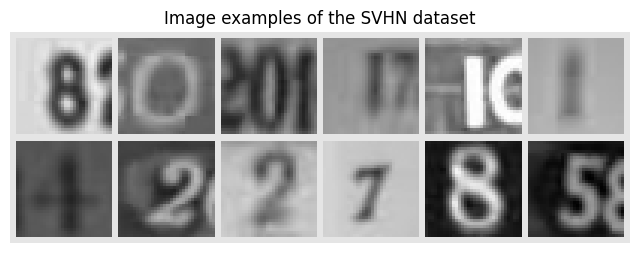

In [11]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack(
    [
        SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0]
        for idx in range(NUM_IMAGES)
    ],
    dim=0,
)
img_grid = torchvision.utils.make_grid(
    SVHN_images, nrow=6, normalize=True, pad_value=0.9
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [12]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()

In [13]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()
    )
)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()
    )
)

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [14]:
USPS_train_dataset = USPS(
    root=DATASET_PATH,
    train=True,
    download=True,
    transform=T.Compose([T.Pad(8), T.ToTensor()]),
)
USPS_test_dataset = USPS(
    root=DATASET_PATH,
    train=False,
    download=True,
    transform=T.Compose([T.Pad(8), T.ToTensor()]),
)

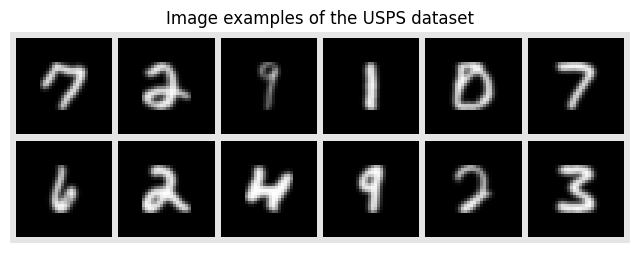

In [15]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack(
    [
        USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0]
        for idx in range(NUM_IMAGES)
    ],
    dim=0,
)
img_grid = torchvision.utils.make_grid(
    USPS_images, nrow=6, normalize=True, pad_value=0.9
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [16]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [17]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()
    )
)

print(
    "Min Pixel Value: {} \nMax Pixel Value: {}".format(
        USPS_Xtest_ima.min(), USPS_Xtest_ima.max()
    )
)
print(
    "Mean Pixel Value {} \nPixel Values Std: {}".format(
        USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()
    )
)

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [18]:
MNIST_Xtrain_ima.shape, type(MNIST_Xtrain_ima)

((60000, 32, 32), numpy.ndarray)

In [19]:
# MNIST
MNIST_Xtrain = MNIST_Xtrain_ima.reshape(MNIST_Xtrain_ima.shape[0], -1)
MNIST_Xtest = MNIST_Xtest_ima.reshape(MNIST_Xtest_ima.shape[0], -1)

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain = USPS_Xtrain_ima.reshape(USPS_Xtrain_ima.shape[0], -1)
USPS_Xtest = USPS_Xtest_ima.reshape(USPS_Xtest_ima.shape[0], -1)

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain = SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0], -1)
SVHN_Xtest = SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0], -1)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [20]:
num_samples = 1000
# Reduced MNIST
random_indices_MNIST = np.random.choice(
    MNIST_Xtrain.shape[0], num_samples, replace=True
)
MNIST_Xtrain_res = MNIST_Xtrain[random_indices_MNIST]
MNIST_ytrain_res = MNIST_ytrain[random_indices_MNIST]

# Reduced USPS
random_indices_USPS = np.random.choice(USPS_Xtrain.shape[0], num_samples, replace=True)
USPS_Xtrain_res = USPS_Xtrain[random_indices_USPS]
USPS_ytrain_res = USPS_ytrain[random_indices_USPS]

# Reduced SVHN
random_indices_SVHN = np.random.choice(SVHN_Xtrain.shape[0], num_samples, replace=True)
SVHN_Xtrain_res = SVHN_Xtrain[random_indices_SVHN]
SVHN_ytrain_res = SVHN_ytrain[random_indices_SVHN]


# Reduced Data
xtot = np.concatenate(
    (MNIST_Xtrain_res, USPS_Xtrain_res, SVHN_Xtrain_res), axis=0
)  # all data
nMNIST = MNIST_Xtrain_res.shape[0]
nUSPS = USPS_Xtrain_res.shape[0]
nSVHN = SVHN_Xtrain_res.shape[0]

print(f"xtot shape: {xtot.shape}, nMNIST: {nMNIST}, nUSPS: {nUSPS}, nSVHN: {nSVHN}")

xtot shape: (3000, 1024), nMNIST: 1000, nUSPS: 1000, nSVHN: 1000


In [24]:
xtot_umap = UMAP().fit_transform(xtot)  # this should take ~50sec

print(xtot_umap.shape)

# separate again but now in 2D
xtot_umap_MNIST = xtot_umap[:nMNIST, :]
xtot_umap_USPS = xtot_umap[nMNIST : nMNIST + nUSPS, :]
xtot_umap_SVHN = xtot_umap[nMNIST + nUSPS :, :]

(3000, 2)


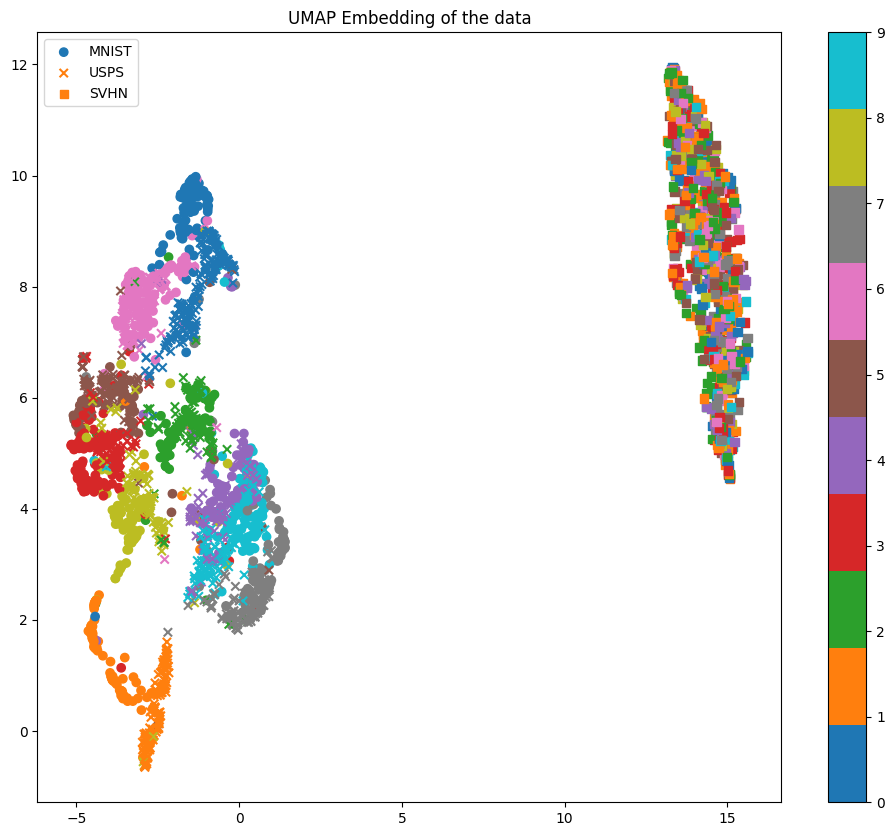

In [25]:
plt.figure(3, (12, 10))

plt.scatter(
    xtot_umap_MNIST[:, 0],
    xtot_umap_MNIST[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    xtot_umap_USPS[:, 0],
    xtot_umap_USPS[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.scatter(
    xtot_umap_SVHN[:, 0],
    xtot_umap_SVHN[:, 1],
    c=SVHN_ytrain_res,
    marker="s",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data")
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

**Answer:** The 2D UMAP visualizations of the MNIST and USPS datasets appear similar when the class distributions in these two datasets are aligned. In contrast, the SVHN dataset shows a distinct distribution. This suggests that MNIST and USPS share similar feature distributions, while the feature distribution of SVHN is significantly different.

In [26]:
x_mnist_usps = np.concatenate((MNIST_Xtrain_res, USPS_Xtrain_res), axis=0)
x_mnist_usps_umap = UMAP().fit_transform(x_mnist_usps)  # this should take ~50sec

print(x_mnist_usps_umap.shape)

# separate again but now in 2D
x_mu_mnist_umap = x_mnist_usps_umap[:nMNIST, :]
x_mu_usps_umap = x_mnist_usps_umap[nMNIST : nMNIST + nUSPS, :]

(2000, 2)


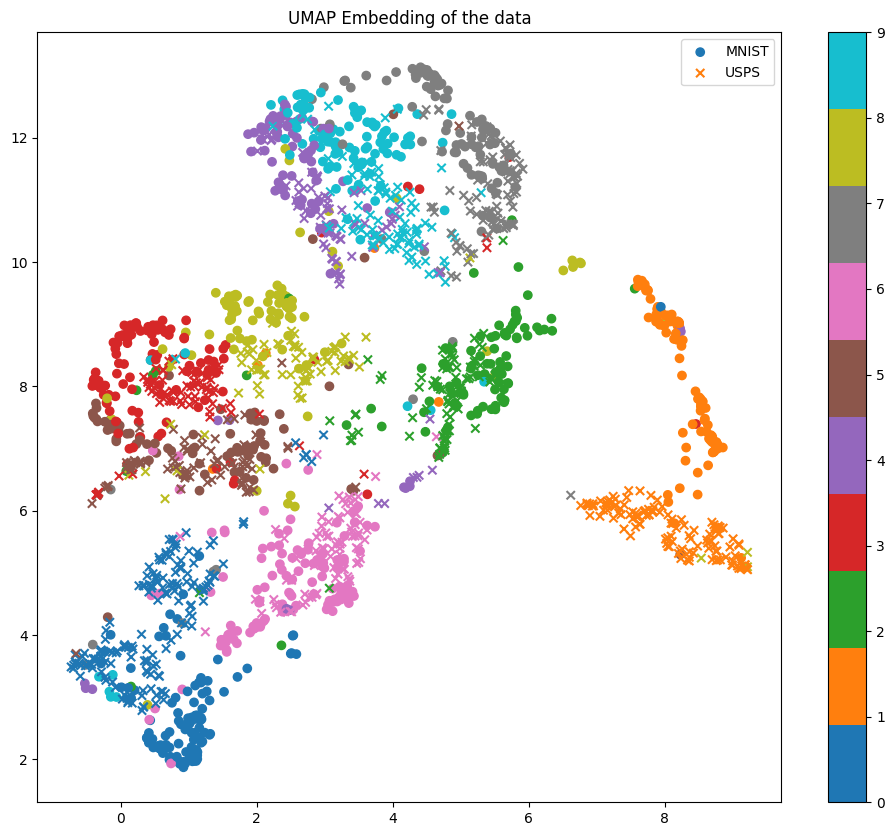

In [27]:
plt.figure(2, (12, 10))

plt.scatter(
    x_mu_mnist_umap[:, 0],
    x_mu_mnist_umap[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_mu_usps_umap[:, 0],
    x_mu_usps_umap[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data")
plt.show()

**Question**: Can you see a domain shift between the datasets ?

**Answer:** From above figure, it is hard to tell that there is a domain shift between MNIST and USPS data set. The distribution of all classes between two datasets are almost the same.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [28]:
%time xtot_tsne = TSNE().fit_transform(xtot) # this should take around 50 sec

print(xtot_tsne.shape)

# separate again but now in 2D
xtot_tsne_MNIST = xtot_tsne[:nMNIST, :]
xtot_tnse_USPS = xtot_tsne[nMNIST : nMNIST + nUSPS, :]
xtot_tsne_SVHN = xtot_tsne[nMNIST + nUSPS :, :]
print(xtot_tsne_MNIST.shape, xtot_tnse_USPS.shape, xtot_tsne_SVHN.shape)

CPU times: user 33.4 s, sys: 219 ms, total: 33.6 s
Wall time: 40.9 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


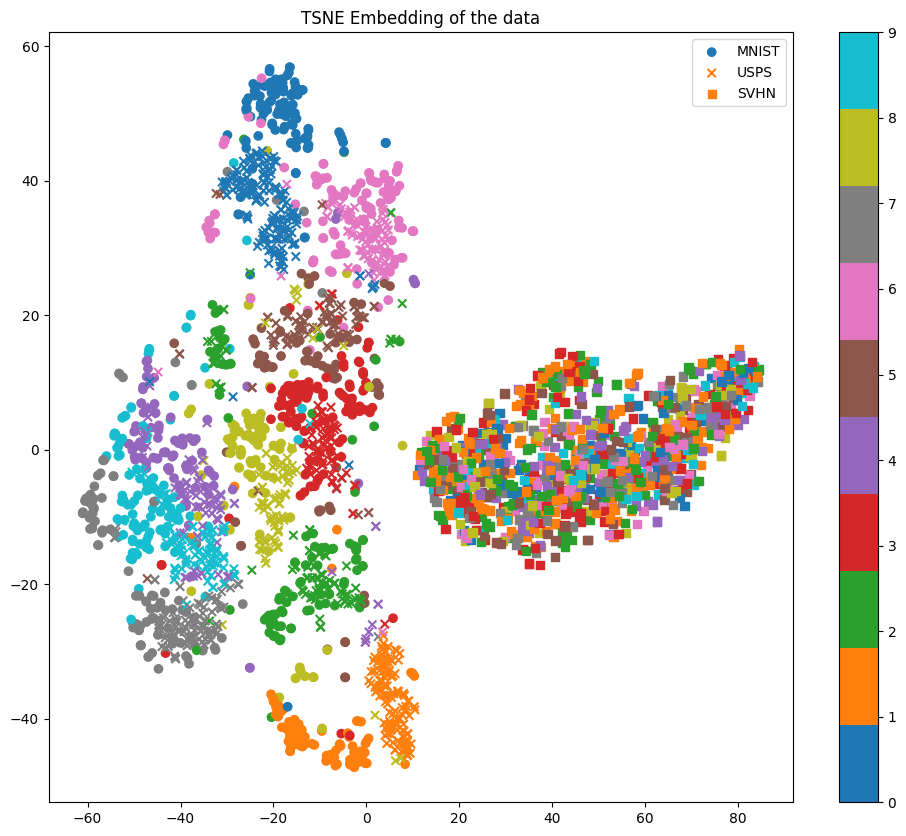

In [30]:
plt.figure(3, (12, 10))

plt.scatter(
    xtot_tsne_MNIST[:, 0],
    xtot_tsne_MNIST[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    xtot_tnse_USPS[:, 0],
    xtot_tnse_USPS[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.scatter(
    xtot_tsne_SVHN[:, 0],
    xtot_tsne_SVHN[:, 1],
    c=SVHN_ytrain_res,
    marker="s",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("TSNE Embedding of the data")
plt.show()

**Question**: can you confirm your previous conclusions ?

**Answer:** The above conclusions are confirmed. The 2D t-SNE visualizations show that MNIST and USPS have closely related feature distributions, whereas SVHN differs significantly in its feature distribution.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

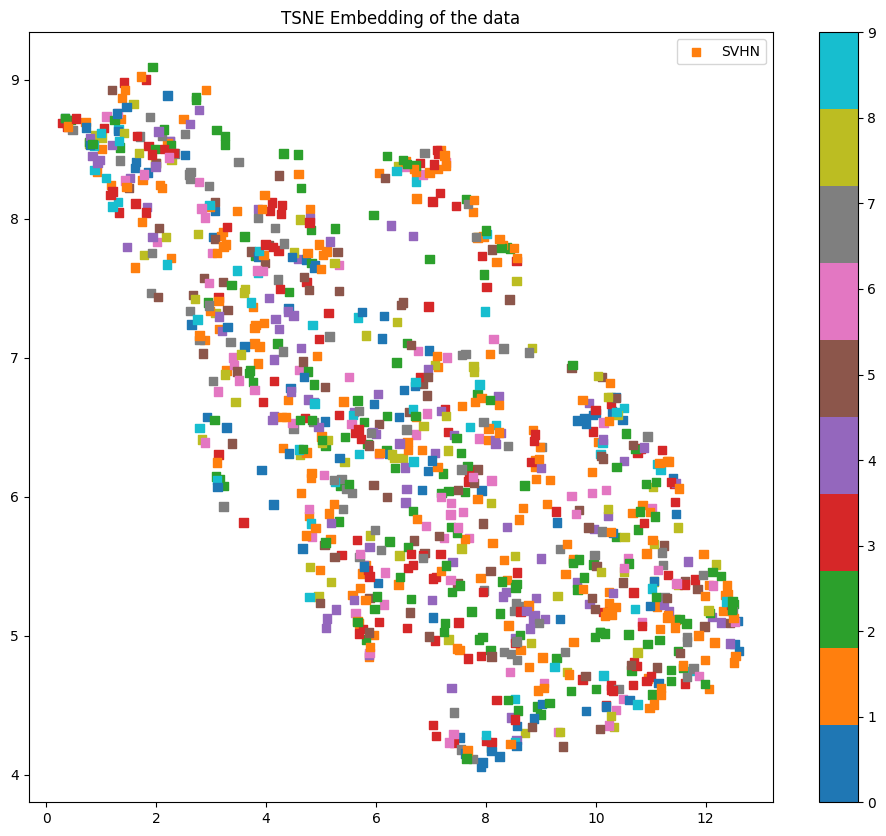

In [31]:
x_SVHN_umap = UMAP().fit_transform(SVHN_Xtrain_res)
plt.figure(1, (12, 10))
plt.scatter(
    x_SVHN_umap[:, 0],
    x_SVHN_umap[:, 1],
    c=SVHN_ytrain_res,
    marker="s",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("TSNE Embedding of the data")
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

**Answer:** For the SVHN dataset, the data is not clearly clustered and well separated. Instead, the classes appear mixed and distributed in a seemingly random manner.

This lack of clear clustering can be attributed to differences in the input space used by UMAP. The SVHN dataset consists of images of house numbers captured in natural scenes, which are more complex and contain higher variability in backgrounds, lighting conditions, and styles. The complexity and diversity in the SVHN input space likely make it more challenging for UMAP to reduce the dimensions in a way that preserves clear class separations. As a result, the feature distribution for SVHN appears less structured and more scattered in the 2D visualization.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [34]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

Ns = 1000  # number of samples in source domain
Nt = 1000  # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [35]:
def SA(XTrainS, XTestS, XTrainT, XTestT, d=10):
    """
    Subspace Alignment (SA)

    Input:
    XTrainS : Input training source data [NTrS, D]
    XTestS : Input test source data [NTeS, D]
    XTrainT : Input training target data [NTrT, D]
    XTestT : Input test target data [NTeT, D]
    d : number of PCA components

    Output:
    XTrainSp : projected and transformed source training data [NTrS, d]
    XTestSp : projected and transformed source test data [NTeS, d]
    XTrainTp : projected training target data [NTrT, d]
    XTestTp : projected test target data [NTeT, d]
    """

    # Compute PCA on the source domain
    pca_S = PCA(n_components=d)
    US = pca_S.fit(XTrainS).components_.T  # PCA components for the source domain
    # print(f"US shape: {US.shape}")  # [D, d]
    XTrainS_pca = XTrainS @ US  # [NTrS, d]
    XTestS_pca = XTestS @ US  # [NTeS, d]

    # Compute PCA on the target domain
    pca_T = PCA(n_components=d)
    UT = pca_T.fit(XTrainT).components_.T  # PCA components for the target domain
    # print(f"UT shape: {UT.shape}")  # [D, d]
    XTrainT_pca = XTrainT @ UT  # [NTrT, d]
    XTestT_pca = XTestT @ UT  # [NTeT, d]

    # Compute the linear transformation matrix M that aligns US to UT
    M_star = US.T @ UT  # Shape [d, d]
    # print(f"M_star shape: {M_star.shape}")

    # Align the source data to the target subspace
    XTrainSp = XTrainS_pca @ M_star  # Transformed source training data, [NTrS, d]
    XTestSp = XTestS_pca @ M_star  # Transformed source test data [NTeS, d]

    # Project the target data into the target subspace
    XTrainTp = XTrainT_pca  # [NTrT, d]
    XTestTp = XTestT_pca  # [NTeT, d]

    return XTrainSp, XTestSp, XTrainTp, XTestTp

We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [36]:
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=10)

In [36]:
# Define the parameter grid for SVC
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ["linear", "poly", "rbf"],  # Different kernel types
    "degree": [3, 4],
    "gamma": [
        "scale",
        "auto",
        0.001,
        0.01,
    ],  # Kernel coefficient (relevant for 'rbf', 'poly')
    "decision_function_shape": ["ovo", "ovr"],  # One-vs-one or one-vs-rest strategy
}

clf = SVC(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=1)
grid_search.fit(XTrainSp, ytrainS)

best_clf = grid_search.best_estimator_

y_testS_pred = best_clf.predict(XTestSp)

cm = confusion_matrix(ytestS, y_testS_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(ytestS, y_testS_pred))

print("\nBest Hyperparameters from Grid Search:")
print(grid_search.best_params_)

Confusion Matrix:
[[ 914    0    5    3    0   14   33    2    6    3]
 [   5 1092    3   13    2    2    4    0   14    0]
 [  20    3  897   19    8    5   25   16   37    2]
 [  12    6   22  843    9   27    3   11   71    6]
 [   6    0   17    0  691    4   26   16    9  213]
 [  27    3   12   58    5  701   14    7   29   36]
 [  35    7   25    3    6    8  859    0    5   10]
 [   8   16   21   10   16    6    0  874   18   59]
 [  10    9   37   63    8   33    9   16  746   43]
 [  10    5    5   19   80    9    3   56   24  798]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       980
           1       0.96      0.96      0.96      1135
           2       0.86      0.87      0.86      1032
           3       0.82      0.83      0.83      1010
           4       0.84      0.70      0.76       982
           5       0.87      0.79      0.82       892
           6       0.88      0.90      0.89     

In [37]:
# Evaluation on the XTestT
y_testT_pred = grid_search.predict(XTestTp)

cm = confusion_matrix(ytestT, y_testT_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(ytestT, y_testT_pred))

Confusion Matrix:
[[ 86   0   2   0  38   5 218   4   0   6]
 [  0 147   0   0  19  91   6   1   0   0]
 [  4  16 130   1  12   6  22   2   2   3]
 [  4  15  20  94   3   4  10   7   7   2]
 [  0   1   3   0 158   3   0   8   4  23]
 [ 26   3   2  20   1  63  17   4  21   3]
 [  1   0   2   0  13   6 147   0   1   0]
 [  0   6   2   0   1   1   0 135   1   1]
 [  0  43   9   4  29   3  10  10  50   8]
 [  0  17   1   0  64   0   0  50   6  39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.24      0.36       359
           1       0.59      0.56      0.57       264
           2       0.76      0.66      0.70       198
           3       0.79      0.57      0.66       166
           4       0.47      0.79      0.59       200
           5       0.35      0.39      0.37       160
           6       0.34      0.86      0.49       170
           7       0.61      0.92      0.73       147
           8       0.54      0.30      0

To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

**Answer:**

I begin by reducing the dimensionality of the data using PCA, applying it to the source training set. I then project all datasets onto the first `d` components, which I refer to as the SA_1 method.

Next, I experiment with different values of `d`, performing the same steps for each. The results are as follows:

- \( d = 10 \): 50.7%
- \( d = 20 \): 59.6%
- \( d = 50 \): 58.3%
- \( d = 100 \): 55.9%
- \( d = 200 \): 55.3%

The highest accuracy achieved is **59.6%** with \( d = 20 \), which is lower than the performance of the original Subspace Alignment (SA) method (63%).


In [ ]:
# Reduce dimesionality using other approach
def SA_1(XTrainS, XTestS, XTrainT, XTestT, d):
    """
    Subspace Alignment (SA)

    Input:
    XTrainS : Input training source data [NTrS, D]
    XTestS : Input test source data [NTeS, D]
    XTrainT : Input training target data [NTrT, D]
    XTestT : Input test target data [NTeT, D]
    d : number of PCA components

    Output:
    XTrainSp : projected and transformed source training data [NTrS, d]
    XTestSp : projected and transformed source test data [NTeS, d]
    XTrainTp : projected training target data [NTrT, d]
    XTestTp : projected test target data [NTeT, d]
    """

    # Compute PCA on the source domain
    pca_S = PCA(n_components=d)
    US = pca_S.fit(XTrainS).components_.T  # PCA components for the source domain [D, d]
    # Project the source data on the first d components
    XTrainSp = XTrainS @ US  # [NTrS, d]
    XTestSp = XTestS @ US  # [NTeS, d]

    # Project the target data into the target subspace
    XTrainTp = XTrainT @ US  # [NTrT, d]
    XTestTp = XTestT @ US  # [NTeT, d]

    return XTrainSp, XTestSp, XTrainTp, XTestTp


XTrainSp, XTestSp, XTrainTp, XTestTp = SA_1(XtrainS, XtestS, XtrainT, XtestT, d=10)

clf = SVC(
    C=10,
    decision_function_shape="ovo",
    degree=3,
    gamma="scale",
    kernel="rbf",
    random_state=42,
)
clf.fit(XTrainSp, ytrainS)

y_testS_pred = clf.predict(XTestSp)

cm = confusion_matrix(ytestS, y_testS_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(ytestS, y_testS_pred))

Confusion Matrix:
[[ 926    0    3    3    0   16   27    1    1    3]
 [   0 1113    4    3    1    0    6    5    3    0]
 [  22    1  929   14    8    3   14   18   22    1]
 [   5    3   23  855    3   41    3   14   53   10]
 [   0    1   15    6  783    7   18    8   12  132]
 [  26    3    9   23   12  770   15    2   24    8]
 [  14    5   18    1   12   13  893    0    2    0]
 [   1   14   34    6    7    4    0  901    7   54]
 [   7    3   27  128    4   25   12    6  735   27]
 [  11   10    2   13   91   15   14   23   16  814]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.97      0.98      0.97      1135
           2       0.87      0.90      0.89      1032
           3       0.81      0.85      0.83      1010
           4       0.85      0.80      0.82       982
           5       0.86      0.86      0.86       892
           6       0.89      0.93      0.91     

In [ ]:
# Evaluation on the XtestT
y_testT_pred = clf.predict(XTestTp)

cm = confusion_matrix(ytestT, y_testT_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(ytestT, y_testT_pred))

Confusion Matrix:
[[ 29   1   6   0 179   6 111  24   0   3]
 [  0 254   0   0   2   1   6   1   0   0]
 [  1   4 144   0  27   8   3   6   4   1]
 [  1   2  66  19   7  11   9  35  16   0]
 [  0   6   6   0 148   8   0  26   2   4]
 [ 11   2  11   1  15  40  42  15  21   2]
 [  0   1   8   0  19   3 139   0   0   0]
 [  0   3   1   0   1   0   0 136   1   5]
 [  2  22  17   0  32   8  16  22  44   3]
 [  0  17   0   0  20   0   0  64  10  66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.08      0.14       359
           1       0.81      0.96      0.88       264
           2       0.56      0.73      0.63       198
           3       0.95      0.11      0.20       166
           4       0.33      0.74      0.46       200
           5       0.47      0.25      0.33       160
           6       0.43      0.82      0.56       170
           7       0.41      0.93      0.57       147
           8       0.45      0.27      0

In [ ]:
# Test with different value of d
d_values = [10, 20, 50, 100, 200]
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA_1(XtrainS, XtestS, XtrainT, XtestT, d)

    clf = SVC(
        C=10,
        decision_function_shape="ovo",
        degree=3,
        gamma="scale",
        kernel="rbf",
        random_state=42,
    )
    clf.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf.predict(XTestTp)

    print(
        f"d = {d}, TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}"
    )

d = 10, TestT accuracy: 0.5072247135027405
d = 20, TestT accuracy: 0.5959142999501744
d = 50, TestT accuracy: 0.5829596412556054
d = 100, TestT accuracy: 0.5585450921773791
d = 200, TestT accuracy: 0.5535625311410065


We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

**Answer:** In this experiment, I tested different values of **d** (the number of features after dimensionality reduction) and evaluated three machine learning models on the **Target test set**:

- **Logistic Regression**: performed the worst with an accuracy of **60.6%** on the Target test set.
  
- **Support Vector Machine (SVM)**: achieved an accuracy of **69.7%** when using **d = 40**.
  
- **Neural Network**: three hidden layers of sizes `[256, 128, 64]`, achieved the same **69.7%** accuracy as the SVM model, also with **d = 40**.

Both the SVM and Neural Network models performed equally well, achieving the highest accuracy of **69.7%** at **d = 40**, suggesting that this value of **d** might capture the most relevant features for classification. The Logistic Regression model, as expected from a linear classifier, struggled to perform well on this particular dataset, achieving significantly lower accuracy.


In [ ]:
# Test with different value of d
d_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500]

# Logistic Regression
clf_logistic = LogisticRegression(
    C=10, solver="lbfgs", max_iter=1000, multi_class="multinomial", random_state=42
)
best_acc_logistic = -1
best_d_logistic = -1
for d in d_values:
    XTrainSp, XTestSp, XtrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    clf_logistic.fit(XTrainSp, ytrainS)

    y_testT_pred = clf_logistic.predict(XTestTp)
    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    if acc > best_acc_logistic:
        best_acc_logistic = acc
        best_d_logistic = d

    print(
        f"d = {d}, TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}"
    )

print(f"Best TestT accuracy: {best_acc_logistic} with d = {best_d_logistic}")

d = 10, TestT accuracy: 0.4190333831589437
d = 20, TestT accuracy: 0.5261584454409567
d = 30, TestT accuracy: 0.5251619332336821
d = 40, TestT accuracy: 0.5854509217737918
d = 50, TestT accuracy: 0.5764823119083209
d = 60, TestT accuracy: 0.5714997508719482
d = 70, TestT accuracy: 0.5919282511210763
d = 80, TestT accuracy: 0.585949177877429
d = 90, TestT accuracy: 0.598903836571998
d = 100, TestT accuracy: 0.5929247633283508
d = 150, TestT accuracy: 0.6033881415047334
d = 200, TestT accuracy: 0.6058794220229198
d = 300, TestT accuracy: 0.6048829098156452
d = 500, TestT accuracy: 0.5705032386646737
Best TestT accuracy: 0.6058794220229198 with d = 200


In [ ]:
# SVM
clf_svc = SVC(
    C=10,
    decision_function_shape="ovo",
    degree=3,
    gamma="auto",
    kernel="rbf",
    random_state=42,
)
best_acc_svc = -1
best_d_svc = -1
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    clf_svc.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf_svc.predict(XTestTp)

    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    if acc > best_acc_svc:
        best_acc_svc = acc
        best_d_svc = d

    print(
        f"d = {d}, TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}"
    )

print(f"Best TestT accuracy: {best_acc_svc} with d = {best_d_svc}")

d = 10, TestT accuracy: 0.5814648729446936
d = 20, TestT accuracy: 0.6846038863976084
d = 30, TestT accuracy: 0.6895864474339811
d = 40, TestT accuracy: 0.6965620328849028
d = 50, TestT accuracy: 0.6910812157448929
d = 60, TestT accuracy: 0.6920777279521674
d = 70, TestT accuracy: 0.693074240159442
d = 80, TestT accuracy: 0.6925759840558047
d = 90, TestT accuracy: 0.695067264573991
d = 100, TestT accuracy: 0.6900847035376183
d = 150, TestT accuracy: 0.6806178375685102
d = 200, TestT accuracy: 0.6711509715994021
d = 300, TestT accuracy: 0.6601893373193821
d = 500, TestT accuracy: 0.6168410563029397
Best TestT accuracy: 0.6965620328849028 with d = 40


In [ ]:
class CustomedNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output(x)
        return self.softmax(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Best accuracy tracking
best_acc_S = -1
best_d_nn = -1
n_epoch = 20

# Test with different values of d
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    XTrainSp_tensor = torch.tensor(XTrainSp, dtype=torch.float32).to(device)
    ytrainS_tensor = torch.tensor(ytrainS, dtype=torch.long).to(device)

    XTestSp_tensor = torch.tensor(XTestSp, dtype=torch.float32).to(device)
    ytestS_tensort = torch.tensor(ytestS, dtype=torch.long).to(device)

    XTestTp_tensor = torch.tensor(XTestTp, dtype=torch.float32).to(device)
    ytestT_tensor = torch.tensor(ytestT, dtype=torch.long).to(device)

    train_data = TensorDataset(XTrainSp_tensor, ytrainS_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    num_classes = len(set(ytrainS))
    model = CustomedNN(input_dim=d, num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(n_epoch):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation on the XTestSp
    model.eval()
    with torch.no_grad():
        y_testS_pred = model(XTestSp_tensor)
        _, y_testS_pred_classes = torch.max(y_testS_pred, 1)
        y_testS_pred_classes = y_testS_pred_classes.cpu().numpy()

    accS = classification_report(ytestS, y_testS_pred_classes, output_dict=True)[
        "accuracy"
    ]

    # Evaluation on the XTestTp
    with torch.no_grad():
        y_testT_pred = model(XTestTp_tensor)
        _, y_testT_pred_classes = torch.max(y_testT_pred, 1)
        y_testT_pred_classes = y_testT_pred_classes.cpu().numpy()

    accT = classification_report(ytestT, y_testT_pred_classes, output_dict=True)[
        "accuracy"
    ]

    if accS > best_acc_S:
        best_acc_S = accS
        best_d_nn = d
        best_acc_T = accT

    print(f"d = {d}, TestS accuracy: {accS}, TestT accuracy: {accT}")

print(f"Best TestT accuracy: {best_acc_svc} with d = {best_d_svc}")

Using device: cuda
d = 10, TestS accuracy: 0.8023, TestT accuracy: 0.5690084703537618
d = 20, TestS accuracy: 0.8816, TestT accuracy: 0.6606875934230194
d = 30, TestS accuracy: 0.886, TestT accuracy: 0.6392625809666168
d = 40, TestS accuracy: 0.8771, TestT accuracy: 0.6228201295465869
d = 50, TestS accuracy: 0.8845, TestT accuracy: 0.6611858495266567
d = 60, TestS accuracy: 0.8829, TestT accuracy: 0.635774788241156
d = 70, TestS accuracy: 0.8859, TestT accuracy: 0.6567015445939213
d = 80, TestS accuracy: 0.8852, TestT accuracy: 0.617339312406577
d = 90, TestS accuracy: 0.8822, TestT accuracy: 0.6586945690084703
d = 100, TestS accuracy: 0.8797, TestT accuracy: 0.6258096661684106
d = 150, TestS accuracy: 0.8673, TestT accuracy: 0.6003986048829099
d = 200, TestS accuracy: 0.7917, TestT accuracy: 0.5326357747882412
d = 300, TestS accuracy: 0.8567, TestT accuracy: 0.591429995017439
d = 500, TestS accuracy: 0.8534, TestT accuracy: 0.543597409068261
Best TestT accuracy: 0.6965620328849028 wit

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

**Answer:** Below are the UMAP and t-SNE visualizations of the MNIST and USPS datasets before and after Subspace Alignment (SA) adaptation (**with d=40**). The visualizations show that the data distributions before and after adaptation remain largely similar.

This observation suggests that there is minimal or no domain shift between the MNIST and USPS datasets. As a result, applying Subspace Alignment does not significantly alter the data distributions, as the two datasets already share closely aligned feature spaces.

In [41]:
# UMAP
# First I fit the XtrainS, XTrainT with UMAP -> before SA
x_ST = np.concatenate((XtrainS, XtrainT), axis=0)
x_ST_umap = UMAP().fit_transform(x_ST)

x_S_umap = x_ST_umap[:nMNIST, :]
x_T_umap = x_ST_umap[nMNIST : nMNIST + nUSPS, :]
print(x_S_umap.shape, x_T_umap.shape)

(1000, 2) (1000, 2)


In [42]:
# Then I fit the XTrainSp, XTrainTp with UMAP -> after SA
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=40)
x_ST_SA = np.concatenate((XTrainSp, XTrainTp), axis=0)
x_ST_SA_umap = UMAP().fit_transform(x_ST_SA)

x_S_SA_umap = x_ST_SA_umap[:nMNIST, :]
x_T_SA_umap = x_ST_SA_umap[nMNIST : nMNIST + nUSPS, :]
print(x_S_SA_umap.shape, x_T_SA_umap.shape)

(1000, 2) (1000, 2)


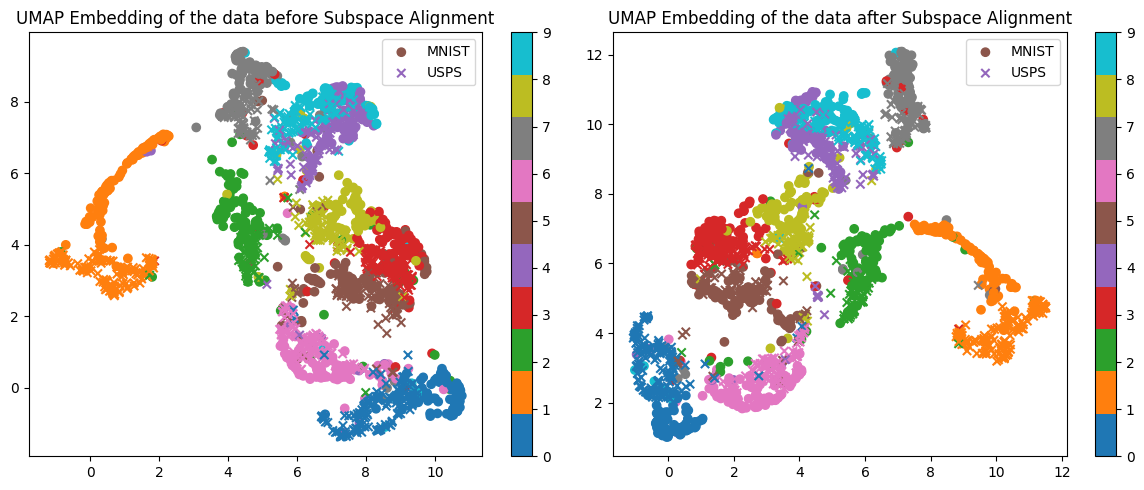

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(
    x_S_umap[:, 0],
    x_S_umap[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_umap[:, 0],
    x_T_umap[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data before Subspace Alignment")

plt.subplot(1, 2, 2)
plt.scatter(
    x_S_SA_umap[:, 0],
    x_S_SA_umap[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_SA_umap[:, 0],
    x_T_SA_umap[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data after Subspace Alignment")

plt.tight_layout()
plt.show()

In [44]:
# UMAP
# First I fit the XtrainS, XTrainT with UMAP -> before SA
x_ST_tsne = TSNE().fit_transform(x_ST)
x_S_tsne = x_ST_tsne[:nMNIST, :]
x_T_tsne = x_ST_tsne[nMNIST : nMNIST + nUSPS, :]
print(x_S_tsne.shape, x_T_tsne.shape)

(1000, 2) (1000, 2)


In [45]:
# after SA
x_ST_SA_tsne = TSNE().fit_transform(x_ST_SA)
x_S_SA_tsne = x_ST_SA_tsne[:nMNIST, :]
x_T_SA_tsne = x_ST_SA_tsne[nMNIST : nMNIST + nUSPS, :]
print(x_S_SA_tsne.shape, x_T_SA_tsne.shape)

(1000, 2) (1000, 2)


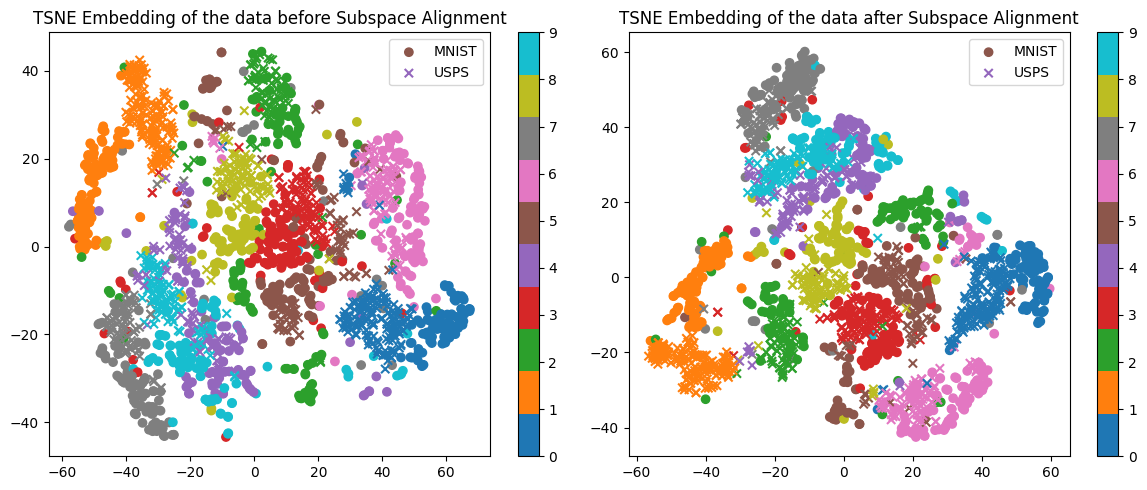

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(
    x_S_tsne[:, 0],
    x_S_tsne[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_tsne[:, 0],
    x_T_tsne[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.legend()
plt.colorbar()
plt.title("TSNE Embedding of the data before Subspace Alignment")

plt.subplot(1, 2, 2)
plt.scatter(
    x_S_SA_tsne[:, 0],
    x_S_SA_tsne[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_SA_tsne[:, 0],
    x_T_SA_tsne[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="USPS",
)
plt.legend()
plt.colorbar()
plt.title("TSNE Embedding of the data after Subspace Alignment")

plt.tight_layout()
plt.show()

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Question**: Comment the results

**Answer:** The experiment above utilized MNIST as the Source and USPS as the Target dataset. Below, I present additional experiments with MNIST as the Source and SVHN as the Target.

The results show that the accuracy on the Target test set is very low, approximately 17%. Visualizations using UMAP and t-SNE indicate that the class distributions of MNIST and SVHN remain significantly different and largely separated.

This outcome suggests that subspace alignment, which relies on linear transformation using PCA, is ineffective in this case. The method fails to adequately align the Source (MNIST) and Target (SVHN) feature spaces, likely due to the significant differences in their underlying data distributions and complexities.

In [47]:
# Here I repeat the same experiments with source MNIST, Target SVHN
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns = 1000  # number of samples in source domain
Nt = 1000  # number of samples in target domain

In [50]:
# Logistic Regression
clf_logistic = LogisticRegression(
    C=10, solver="lbfgs", max_iter=1000, multi_class="multinomial", random_state=42
)
best_acc_logistic = -1
best_d_logistic = -1
for d in d_values:
    XTrainSp, XTestSp, XtrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    clf_logistic.fit(XTrainSp, ytrainS)

    y_testT_pred = clf_logistic.predict(XTestTp)
    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    if acc > best_acc_logistic:
        best_acc_logistic = acc
        best_d_logistic = d

    print(
        f"d = {d}, TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}"
    )

print(f"Best TestT accuracy: {best_acc_logistic} with d = {best_d_logistic}")

d = 10, TestT accuracy: 0.10271972956361401
d = 20, TestT accuracy: 0.14697295636140134
d = 30, TestT accuracy: 0.15918869084204057
d = 40, TestT accuracy: 0.1624154886293792
d = 50, TestT accuracy: 0.15146742470805163
d = 60, TestT accuracy: 0.13345113706207745
d = 70, TestT accuracy: 0.09745697602950215
d = 80, TestT accuracy: 0.11251536570374923
d = 90, TestT accuracy: 0.10613859864781806
d = 100, TestT accuracy: 0.12968653964351567
d = 150, TestT accuracy: 0.11105562384757221
d = 200, TestT accuracy: 0.11482022126613399
d = 300, TestT accuracy: 0.16552704363859866
d = 500, TestT accuracy: 0.17355562384757223
Best TestT accuracy: 0.17355562384757223 with d = 500


In [51]:
# SVM
clf_svc = SVC(
    C=10,
    decision_function_shape="ovo",
    degree=3,
    gamma="auto",
    kernel="rbf",
    random_state=42,
)
best_acc_svc = -1
best_d_svc = -1
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    clf_svc.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf_svc.predict(XTestTp)

    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    if acc > best_acc_svc:
        best_acc_svc = acc
        best_d_svc = d

    print(
        f"d = {d}, TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}"
    )

print(f"Best TestT accuracy: {best_acc_svc} with d = {best_d_svc}")

d = 10, TestT accuracy: 0.1861939151813153
d = 20, TestT accuracy: 0.19479870928088505
d = 30, TestT accuracy: 0.0895820528580209
d = 40, TestT accuracy: 0.09157959434542103
d = 50, TestT accuracy: 0.09311616472034419
d = 60, TestT accuracy: 0.10214351567301783
d = 70, TestT accuracy: 0.10763675476336816
d = 80, TestT accuracy: 0.107559926244622
d = 90, TestT accuracy: 0.11205439459127228
d = 100, TestT accuracy: 0.11393669330055317
d = 150, TestT accuracy: 0.12254148740012293
d = 200, TestT accuracy: 0.1378303626306085
d = 300, TestT accuracy: 0.15565457897971727
d = 500, TestT accuracy: 0.15569299323909036
Best TestT accuracy: 0.19479870928088505 with d = 20


In [52]:
# Best accuracy tracking
best_acc_S = -1
best_d_nn = -1
n_epoch = 20

# Test with different values of d
for d in d_values:
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    XTrainSp_tensor = torch.tensor(XTrainSp, dtype=torch.float32).to(device)
    ytrainS_tensor = torch.tensor(ytrainS, dtype=torch.long).to(device)

    XTestSp_tensor = torch.tensor(XTestSp, dtype=torch.float32).to(device)
    ytestS_tensort = torch.tensor(ytestS, dtype=torch.long).to(device)

    XTestTp_tensor = torch.tensor(XTestTp, dtype=torch.float32).to(device)
    ytestT_tensor = torch.tensor(ytestT, dtype=torch.long).to(device)

    train_data = TensorDataset(XTrainSp_tensor, ytrainS_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    num_classes = len(set(ytrainS))
    model = CustomedNN(input_dim=d, num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(n_epoch):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation on the XTestSp
    model.eval()
    with torch.no_grad():
        y_testS_pred = model(XTestSp_tensor)
        _, y_testS_pred_classes = torch.max(y_testS_pred, 1)
        y_testS_pred_classes = y_testS_pred_classes.cpu().numpy()

    accS = classification_report(ytestS, y_testS_pred_classes, output_dict=True)["accuracy"]

    # Evaluation on the XTestTp
    with torch.no_grad():
        y_testT_pred = model(XTestTp_tensor)
        _, y_testT_pred_classes = torch.max(y_testT_pred, 1)
        y_testT_pred_classes = y_testT_pred_classes.cpu().numpy()

    accT = classification_report(ytestT, y_testT_pred_classes, output_dict=True)["accuracy"]

    if accS > best_acc_S:
        best_acc_S = accS
        best_d_nn = d
        best_acc_T = accT

    print(f"d = {d}, TestS accuracy: {accS}, TestT accuracy: {accT}")

print(f"Best TestT accuracy: {best_acc_svc} with d = {best_d_svc}")

Using device: cuda
d = 10, TestS accuracy: 0.5784, TestT accuracy: 0.07821143208358942
d = 20, TestS accuracy: 0.6745, TestT accuracy: 0.09065765212046711
d = 30, TestS accuracy: 0.8501, TestT accuracy: 0.1663721573448064
d = 40, TestS accuracy: 0.8114, TestT accuracy: 0.10318070067609096
d = 50, TestS accuracy: 0.8159, TestT accuracy: 0.12680547019053473
d = 60, TestS accuracy: 0.8204, TestT accuracy: 0.13314382298709282
d = 70, TestS accuracy: 0.8814, TestT accuracy: 0.1687538414259373
d = 80, TestS accuracy: 0.8348, TestT accuracy: 0.1290719114935464
d = 90, TestS accuracy: 0.8268, TestT accuracy: 0.17186539643515672
d = 100, TestS accuracy: 0.8896, TestT accuracy: 0.1387138905961893
d = 150, TestS accuracy: 0.8299, TestT accuracy: 0.11927627535341119
d = 200, TestS accuracy: 0.8676, TestT accuracy: 0.1465119852489244
d = 300, TestS accuracy: 0.7946, TestT accuracy: 0.1379840196681008
d = 500, TestS accuracy: 0.7915, TestT accuracy: 0.12169637369391519
Best TestT accuracy: 0.1947987

(1000, 2) (1000, 2)
(1000, 2) (1000, 2)


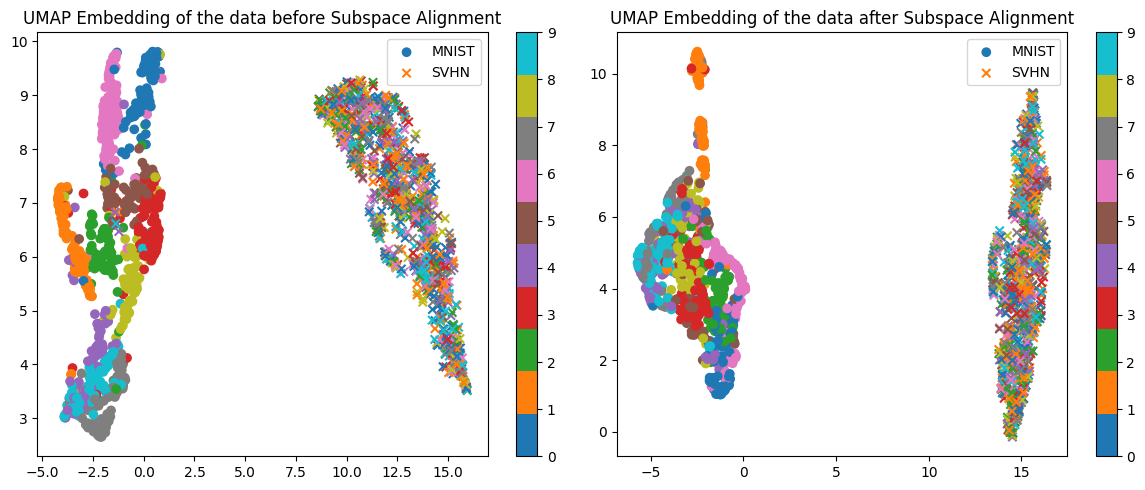

In [57]:
# UMAP
# First I fit the XtrainS, XTrainT with UMAP -> before SA
x_ST = np.concatenate((XtrainS, XtrainT), axis=0)
x_ST_umap = UMAP().fit_transform(x_ST)

x_S_umap = x_ST_umap[:nMNIST, :]
x_T_umap = x_ST_umap[nMNIST : nMNIST + nUSPS, :]
print(x_S_umap.shape, x_T_umap.shape)

# Then I fit the XTrainSp, XTrainTp with UMAP -> after SA
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=20)
x_ST_SA = np.concatenate((XTrainSp, XTrainTp), axis=0)
x_ST_SA_umap = UMAP().fit_transform(x_ST_SA)

x_S_SA_umap = x_ST_SA_umap[:nMNIST, :]
x_T_SA_umap = x_ST_SA_umap[nMNIST : nMNIST + nUSPS, :]
print(x_S_SA_umap.shape, x_T_SA_umap.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(
    x_S_umap[:, 0],
    x_S_umap[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_umap[:, 0],
    x_T_umap[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data before Subspace Alignment")

plt.subplot(1, 2, 2)
plt.scatter(
    x_S_SA_umap[:, 0],
    x_S_SA_umap[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_SA_umap[:, 0],
    x_T_SA_umap[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data after Subspace Alignment")

plt.tight_layout()
plt.show()

(1000, 2) (1000, 2)
(1000, 2) (1000, 2)


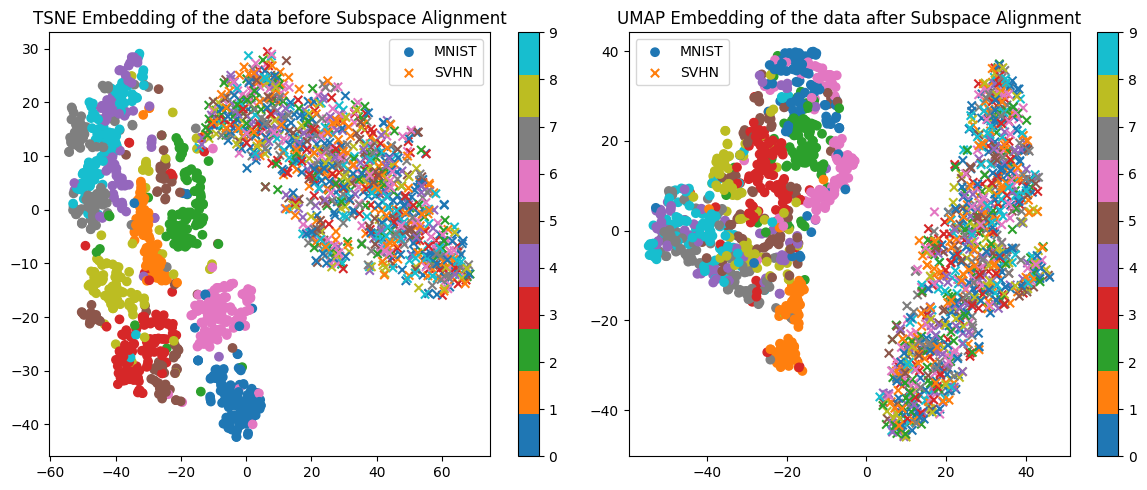

In [58]:
# TSNE
# First I fit the XtrainS, XTrainT with UMAP -> before SA
x_ST_tsne = TSNE().fit_transform(x_ST)

x_S_tsne = x_ST_tsne[:nMNIST, :]
x_T_tsne = x_ST_tsne[nMNIST : nMNIST + nUSPS, :]
print(x_S_tsne.shape, x_T_tsne.shape)

# after SA
x_ST_SA_tsne = TSNE().fit_transform(x_ST_SA)

x_S_SA_tsne = x_ST_SA_tsne[:nMNIST, :]
x_T_SA_tsne = x_ST_SA_tsne[nMNIST : nMNIST + nUSPS, :]
print(x_S_SA_tsne.shape, x_T_SA_tsne.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(
    x_S_tsne[:, 0],
    x_S_tsne[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_tsne[:, 0],
    x_T_tsne[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("TSNE Embedding of the data before Subspace Alignment")

plt.subplot(1, 2, 2)
plt.scatter(
    x_S_SA_tsne[:, 0],
    x_S_SA_tsne[:, 1],
    c=MNIST_ytrain_res,
    marker="o",
    cmap="tab10",
    label="MNIST",
)
plt.scatter(
    x_T_SA_tsne[:, 0],
    x_T_SA_tsne[:, 1],
    c=USPS_ytrain_res,
    marker="x",
    cmap="tab10",
    label="SVHN",
)
plt.legend()
plt.colorbar()
plt.title("UMAP Embedding of the data after Subspace Alignment")

plt.tight_layout()
plt.show()

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

**Answer**:

Below, I outline experiments to test the impact of decreasing the number of labeled samples in the source training set while keeping the target data constant. The experiments include three different source data sizes:

- Source data size = 700
- Source data size = 500
- Source data size = 300

As the source dataset size decreases, the accuracy on the target test set also decreases. This trend indicates that a smaller source dataset provides less information to align the source and target domains, making it harder for the model to generalize to the target domain.

In [92]:
# To check this, here I test with source data = MNIST, target data = USPS
# I reduce MNIST to 700 samples, and keep the same 1000 samples in USPS

n_tests = 50
acc_store_700 = []

for _ in range(n_tests):
    random_indices_MNIST = np.random.choice(MNIST_Xtrain.shape[0], 700, replace=True)
    MNIST_Xtrain_res = MNIST_Xtrain[random_indices_MNIST]
    MNIST_ytrain_res = MNIST_ytrain[random_indices_MNIST]

    # Source domain
    XtrainS = MNIST_Xtrain_res
    ytrainS = MNIST_ytrain_res
    XtestS = MNIST_Xtest
    ytestS = MNIST_ytest

    # Target domain
    XtrainT = USPS_Xtrain_res
    ytrainT = USPS_ytrain_res
    XtestT = USPS_Xtest
    ytestT = USPS_ytest

    # print(XtrainS.shape, XtestS.shape, XtrainT.shape, XtestT.shape)

    # SVM
    clf_svc = SVC(
        C=10,
        decision_function_shape="ovo",
        degree=3,
        gamma="auto",
        kernel="rbf",
        random_state=42,
    )

    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=40)

    clf_svc.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf_svc.predict(XTestTp)

    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    acc_store_700.append(acc)

    # print(f"TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}")

In [93]:
print(np.mean(acc_store_700), np.std(acc_store_700))

0.6872645739910312 0.02468266595996621


In [94]:
# I reduce MNIST to 500 samples, and keep the same 1000 samples in USPS

acc_store_500 = []
for _ in range(n_tests):
    random_indices_MNIST = np.random.choice(MNIST_Xtrain.shape[0], 500, replace=True)
    MNIST_Xtrain_res = MNIST_Xtrain[random_indices_MNIST]
    MNIST_ytrain_res = MNIST_ytrain[random_indices_MNIST]

    # Source domain
    XtrainS = MNIST_Xtrain_res
    ytrainS = MNIST_ytrain_res
    XtestS = MNIST_Xtest
    ytestS = MNIST_ytest

    # Target domain
    XtrainT = USPS_Xtrain_res
    ytrainT = USPS_ytrain_res
    XtestT = USPS_Xtest
    ytestT = USPS_ytest

    # print(XtrainS.shape, XtestS.shape, XtrainT.shape, XtestT.shape)

    # SVM
    clf_svc = SVC(
        C=10,
        decision_function_shape="ovo",
        degree=3,
        gamma="auto",
        kernel="rbf",
        random_state=42,
    )

    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=40)

    clf_svc.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf_svc.predict(XTestTp)

    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    acc_store_500.append(acc)

    # print(f"TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}")

In [95]:
print(np.mean(acc_store_500), np.std(acc_store_500))

0.6703338315894369 0.02596440428031291


In [104]:
# I reduce MNIST to 100 samples, and keep the same 1000 samples in USPS

acc_store_300 = []
for _ in range(n_tests):
    random_indices_MNIST = np.random.choice(MNIST_Xtrain.shape[0], 300, replace=True)
    MNIST_Xtrain_res = MNIST_Xtrain[random_indices_MNIST]
    MNIST_ytrain_res = MNIST_ytrain[random_indices_MNIST]

    # Source domain
    XtrainS = MNIST_Xtrain_res
    ytrainS = MNIST_ytrain_res
    XtestS = MNIST_Xtest
    ytestS = MNIST_ytest

    # Target domain
    XtrainT = USPS_Xtrain_res
    ytrainT = USPS_ytrain_res
    XtestT = USPS_Xtest
    ytestT = USPS_ytest

    # print(XtrainS.shape, XtestS.shape, XtrainT.shape, XtestT.shape)

    # SVM
    clf_svc = SVC(
        C=10,
        decision_function_shape="ovo",
        degree=3,
        gamma="auto",
        kernel="rbf",
        random_state=42,
    )

    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=40)

    clf_svc.fit(XTrainSp, ytrainS)

    # Evaluation on the testT
    y_testT_pred = clf_svc.predict(XTestTp)

    acc = classification_report(ytestT, y_testT_pred, output_dict=True)["accuracy"]
    acc_store_300.append(acc)

    # print(f"TestT accuracy: {classification_report(ytestT, y_testT_pred, output_dict=True)['accuracy']}")

In [100]:
print(np.mean(acc_store_300), np.std(acc_store_300))

0.6298156452416542 0.0239210591497318


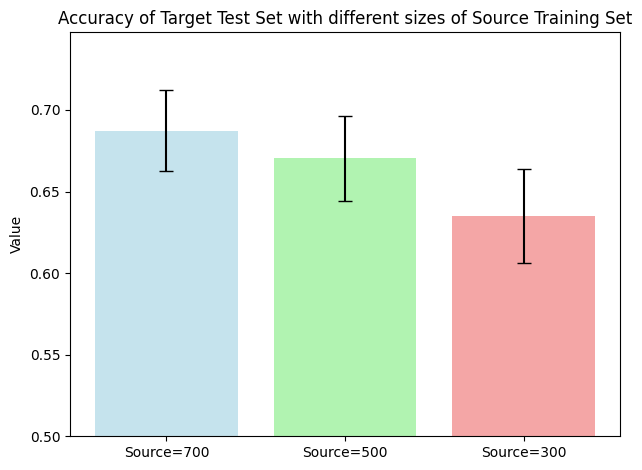

In [105]:
# Calculate mean and standard deviation for each acc_store
means = [np.mean(acc_store_700), np.mean(acc_store_500), np.mean(acc_store_300)]
stds = [np.std(acc_store_700), np.std(acc_store_500), np.std(acc_store_300)]

colors = ["lightblue", "lightgreen", "lightcoral"]

x = np.arange(3)
fig, ax = plt.subplots()

ax.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(["Source=700", "Source=500", "Source=300"])
ax.set_ylabel("Value")
ax.set_title("Accuracy of Target Test Set with different sizes of Source Training Set")
ax.set_ylim(bottom=0.5)

plt.tight_layout()
plt.show()

**Optional**: You can test other methods using the `adapt`library. See `https://adapt-python.github.io/adapt/`

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

**Note:**  `adapt` library works with tensortflow version <= 2.12. If using GG Colab, we need to downgrade tensorflow version.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from adapt.feature_based import DANN
from adapt.feature_based import MDD

In [22]:
random_indices_MNIST = np.random.choice(MNIST_Xtrain.shape[0], 1000, replace=True)
MNIST_Xtrain_res = MNIST_Xtrain[random_indices_MNIST]
MNIST_ytrain_res = MNIST_ytrain[random_indices_MNIST]

# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns = 1000  # number of samples in source domain
Nt = 1000  # number of samples in target domain

**MDD Method**

In [33]:
# Define the encoder
encoder = models.Sequential(
    [
        layers.InputLayer(input_shape=(XtrainS.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
    ]
)

# Define the classification task
task = models.Sequential(
    [
        layers.InputLayer(input_shape=(encoder.output_shape[1],)),
        layers.Dense(10, activation="relu"),
        layers.Dense(
            10, activation="softmax"
        ),  # for MNIST/SVHN classification
    ]
)

# Initialize the MDD model
model = MDD(
    encoder=encoder,  # Encoder network
    task=task,  # Task network
    lambda_=0.1,  # Regularization strength for domain alignment
    gamma=4.0,  # MDD margin parameter
    Xt=XtrainT,  # Target data SVHN
    metrics=["accuracy"],
    random_state=0,
)

# Convert ytrainS to one-hot encoding
ytrainS_onehot = to_categorical(ytrainS, num_classes=10)

model.fit(XtrainS, ytrainS_onehot, epochs=100, verbose=0)

# Evaluate on the XtrainT
accuracy = model.score(XtrainT, ytrainT)
print(f"Accuracy on target data: {accuracy}")

1/1 [==============================] - 0s 142ms/step - loss: 20.7972 - accuracy: 0.0000e+00
Accuracy on target data: 20.797199249267578


**DANN Method**

In [27]:
# Define the encoder (feature extractor) network
encoder = models.Sequential(
    [
        layers.InputLayer(
            input_shape=(XtrainS.shape[1],)
        ),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
    ]
)

# Define the task (classification)
task = models.Sequential(
    [
        layers.InputLayer(
            input_shape=(encoder.output_shape[1],)
        ),  # Input from the encoder
        layers.Dense(10, activation="relu"),
        layers.Dense(
            10, activation="softmax"
        ),
    ]
)

# Define the discriminator network used for domain adaptation
discriminator = models.Sequential(
    [
        layers.InputLayer(
            input_shape=(encoder.output_shape[1],)
        ),  # Input from the encoder
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(
            1, activation="sigmoid"
        ),  # Output is a binary classification (source/target)
    ]
)

# Initialize the DANN model
model = DANN(
    encoder=encoder,  # Feature extractor
    task=task,  # Classification head
    discriminator=discriminator,  # Discriminator for domain adaptation
    lambda_=0.1,  # Regularization strength for domain adaptation
    Xt=XtrainT,  # Target domain data
    yt=ytrainT,  # Target domain labels
    metrics=["accuracy"],
    random_state=42,
)

ytrainS_onehot = to_categorical(ytrainS, num_classes=10)

model.fit(XtrainS, ytrainS_onehot, epochs=100, verbose=0)

# Evaluate on XTrainT
accuracy = model.score(XtrainT, ytrainT)
print(f"Accuracy on target data: {accuracy}")

1/1 [==============================] - 0s 188ms/step - loss: 20.7956 - accuracy: 0.0000e+00
Accuracy on target data: 20.79564666748047



**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...

**Answer:** Here I use pre-trained ResNet50 as the encoder. The accuracy is not improved too much, more or less than 20%.

In [30]:
# Remove the classification head and add a dense layer
base_encoder = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
encoder = models.Sequential(
    [
        base_encoder,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation="relu"),  # Match the original input size (1024)
    ]
)

# Define the task network (classification head)
task = models.Sequential(
    [layers.InputLayer(input_shape=(1024,)), layers.Dense(10, activation="softmax")]
)

# Define the discriminator network
discriminator = models.Sequential(
    [
        layers.InputLayer(input_shape=(1024,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# Reshape the input data to be compatible with the ResNet50 input shape
XtrainS_reshaped = XtrainS.reshape(-1, 32, 32, 1)
XtrainT_reshaped = XtrainT.reshape(-1, 32, 32, 1)

# Duplicate the grayscale channel to create 3 channels (RGB)
XtrainS_reshaped = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(XtrainS_reshaped, dtype=tf.float32)
)
XtrainT_reshaped = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(XtrainT_reshaped, dtype=tf.float32)
)

model = DANN(
    encoder=encoder,
    task=task,
    discriminator=discriminator,
    lambda_=0.1,
    Xt=XtrainT_reshaped,
    yt=ytrainT,
    metrics=["accuracy"],
    random_state=0,
)

# Convert ytrainS to one-hot encoding
ytrainS_onehot = to_categorical(ytrainS, num_classes=10)

model.fit(
    XtrainS_reshaped, ytrainS_onehot, epochs=10, verbose=1
)

# Evaluate on XtrainT
accuracy = model.score(XtrainT_reshaped, ytrainT)
print(f"Accuracy on target data: {accuracy}")

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
32/32 [==============================] - 171s 4s/step - loss: 0.1313 - accuracy: 0.1768 - disc_loss: 5.1055 - disc_acc: 0.4773
Epoch 2/10
32/32 [==============================] - 126s 4s/step - loss: 0.1412 - accuracy: 0.2051 - disc_loss: 6.1310 - disc_acc: 0.3826
Epoch 3/10
32/32 [==============================] - 126s 4s/step - loss: 0.1539 - accuracy: 0.1406 - disc_loss: 5.6601 - disc_acc: 0.3205
Epoch 4/10
32/32 [==============================] - 124s 4s/step - loss: 0.1523 - accuracy: 0.1445 - disc_loss: 5.5286 - disc_acc: 0.3613
Epoch 5/10
32/32 [==============================] - 124s 4s/step - loss: 0.1608 - accuracy: 0.1064 - disc_loss: 5.2781 - disc_acc: 0.3849
Epoch 6/10
32/32 [==============================] - 123s 4s/step - loss: 0.1462 - accuracy: 0.1201 - disc_loss: 4.9769 - disc_acc: 0.4072
Epoch 7/10
32/32 [==============================] - 150s 5s/step - loss: 0.1308 - accuracy: 0.1641 - disc_l

In [31]:
# Evaluate the on XtestT
XtestT_reshaped = XtestT.reshape(-1, 32, 32, 1)
XtestT_reshaped = tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(XtestT_reshaped, dtype=tf.float32)
)

accuracy = model.score(XtestT_reshaped, ytestT)
print(f"Accuracy on target data: {accuracy}")

1/1 [==============================] - 150s 150s/step - loss: 20.5979 - accuracy: 0.0000e+00
Accuracy on target data: 20.597890853881836
